In [39]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor


In [26]:
# Load and read CSV file
df = pd.read_csv('gw.csv')
df.head()

,yyyymm,dfy_lag1,infl_lag1,svar_lag1,de_lag1,lty_lag1,tms_lag1,tbl_lag1,dfr_lag1,dp_lag1,dy_lag1,ltr_lag1,ep_lag1,b/m_lag1,ntis_lag1,CRSP_SPvw_minus_Rfree
0,192701,0.0100,0.000000,0.000465,-0.586175,0.0354,0.0047,0.0307,-0.0022,-2.973012,-2.956570,0.0078,-2.386837,0.441476,0.050876,-0.005410
1,192702,0.0095,-0.011299,0.000470,-0.567601,0.0351,0.0028,0.0323,-0.0019,-2.942374,-2.963349,0.0075,-2.374773,0.443706,0.050824,0.042922
2,192703,0.0092,-0.005714,0.000287,-0.549182,0.0347,0.0018,0.0329,-0.0019,-2.979535,-2.932946,0.0088,-2.430353,0.428501,0.051668,0.004324
3,192704,0.0092,-0.005747,0.000924,-0.531456,0.0331,0.0011,0.0320,-0.0170,-2.976535,-2.970053,0.0253,-2.445079,0.469765,0.046357,0.010521
4,192705,0.0090,0.000000,0.000603,-0.512916,0.0333,-0.0006,0.0339,0.0060,-2.984225,-2.967143,-0.0005,-2.471309,0.456754,0.050514,0.059353


In [4]:
y = df['CRSP_SPvw_minus_Rfree']

predictor_columns = []
for columns in df.columns:
    if columns != 'CRSP_SPvw_minus_Rfree' and columns != 'yyyymm':
        predictor_columns.append(columns)

# predictor_columns

## Part (a): Individual Predictors

In [8]:
# Regress each S&P returns on each predictor using full sample data
linear_model = LinearRegression()
in_sample_r2 = {}

for pred in predictor_columns:
    X = df[[pred]]
    linear_model.fit(X, y)
    y_pred = linear_model.predict(X)
    r2 = r2_score(y, y_pred)
    in_sample_r2[pred] = r2
    # print(f'Pred: {pred}, R^2: {r2}')

in_sample_results = pd.DataFrame.from_dict(in_sample_r2, orient='index', columns=['In-Sample R²'])

# in_sample_results

In [9]:
# OOS performance

# Find where 1965 starts
df['year'] = df['yyyymm'] // 100
start_1965 = df[df['year'] >= 1965].index[0]

oos_r2 = {}

for pred in predictor_columns:
    predictions = []
    actuals = []
    historical_means = []
    
    for t in range(start_1965, len(df)):
        # Train on all data BEFORE time t
        X_train = df.loc[:t-1, [pred]]
        y_train = y.iloc[:t]
        
        # Test on time t
        X_test = df.loc[[t], [pred]]
        y_test = y.iloc[t]
        
        # Fit and predict
        linear_model.fit(X_train, y_train)
        y_pred = linear_model.predict(X_test)[0]
        predictions.append(y_pred)
        actuals.append(y_test)
        historical_means.append(y_train.mean())
    
    # Calculate R^2
    ss_res = np.sum((np.array(actuals) - np.array(predictions))**2)
    ss_tot = np.sum((np.array(actuals) - np.array(historical_means))**2)
    r2 = 1 - (ss_res / ss_tot)
    oos_r2[pred] = r2
    # print(f'Pred: {pred}, OOS R^2: {r2:.6f}')

oos_results = pd.DataFrame.from_dict(oos_r2, orient='index', columns=['Out-of-Sample R²'])

# oos_results

In [10]:
# Combine R^2 results to a single df to compare
result = pd.concat([in_sample_results, oos_results], axis=1)
result

,In-Sample R²,Out-of-Sample R²
dfy_lag1,0.002671,0.003308
infl_lag1,0.002639,0.004685
svar_lag1,0.000230,-0.005881
de_lag1,0.000024,-0.007561
lty_lag1,0.002113,-0.003289
tms_lag1,0.001544,0.001171
tbl_lag1,0.003436,0.002936
dfr_lag1,0.001046,-0.001940
dp_lag1,0.002990,-0.003560
dy_lag1,0.004023,-0.007610


Many of the OOS R^2s are negative. This means that these predictors have little to no forecasting power for future market returns. A negative OOS R² indicates that using these predictors to forecast returns performs worse than simply using the historical mean return as a forecast.

While the in-sample R^2s show positive relationships, most do not persist out-of-sample. Patterns that represent true predictive signal typically persist out-of-sample, which we do not see here for most predictors. Only a few predictors (infl_lag1, dfy_lag1, tbl_lag1, ltr_lag1, tms_lag1) show small positive OOS R²s, meaning they barely outperform a naive historical mean forecast.

This demonstrates overfitting where the model is fitting to random patterns in the data that do not apply to new time periods.


## Part (b): All Predictors + Regularization

In [11]:
# OOS OLS with all predictors

predictions = []
actuals = []
historical_means = []

for t in range(start_1965, len(df)):
    # Train on all data BEFORE time t
    X_train = df.loc[:t-1, predictor_columns]
    y_train = y.iloc[:t]
        
    # Test on time t
    X_test = df.loc[[t], predictor_columns]
    y_test = y.iloc[t]
        
    # Fit and predict
    linear_model.fit(X_train, y_train)
    y_pred = linear_model.predict(X_test)[0]
    predictions.append(y_pred)
    actuals.append(y_test)
    historical_means.append(y_train.mean())
    
# Calculate R^2
ss_res = np.sum((np.array(actuals) - np.array(predictions))**2)
ss_tot = np.sum((np.array(actuals) - np.array(historical_means))**2)
oos_all_r2 = 1 - (ss_res / ss_tot)

unpenalized_predictions = predictions.copy()
unpenalized_actuals = actuals.copy()

print("OOS R² All Predictors:", oos_all_r2)


OOS R² All Predictors: -0.08197734247140365


The OOS R² with all predictors is -0.082, which is worse than most of the individual predictor R²s from part (a). The best individual predictors (infl_lag1, dfy_lag1, tbl_lag1) achieved small positive R²s around 0.003-0.005, while the all-predictor model achieves -0.082.

This demonstrates  overfitting. When including all 14 predictors simultaneously, the model has more flexibility to fit noise in the training data. The additional predictors amplify the overfitting problem by allowing the model to memorize random patterns that don't generalize to new time periods. The model performs worse than simply forecasting the historical mean.

In [12]:
# Defining parameters
alphas = np.logspace(-4, 2, 50)

# Lasso, Ridge, Elastic net using CV 
# GridSearchCV automatically performs K-fold cross-validation

lasso_cv = GridSearchCV(Lasso(max_iter=10000), 
                        param_grid={'alpha': alphas}, 
                        cv=5, 
                        scoring='r2')

ridge_cv = GridSearchCV(Ridge(), 
                        param_grid={'alpha': alphas}, 
                        cv=5, 
                        scoring='r2')

elastic_cv = GridSearchCV(ElasticNet(max_iter=10000), 
                          param_grid={'alpha': alphas, 'l1_ratio': [0.5]}, 
                          cv=5, 
                          scoring='r2')

models = {'Lasso': lasso_cv, 'Ridge': ridge_cv, 'Elastic Net': elastic_cv}


all_predictions = {}
all_actuals = []
all_historical_means = []
oos_results = {}

for name, model in models.items():
    predictions = []
    actuals = []
    historical_means = []
    
    for t in range(start_1965, len(df)):
        X_train = df.loc[:t-1, predictor_columns]
        y_train = y.iloc[:t]
        
        X_test = df.loc[[t], predictor_columns]
        y_test = y.iloc[t]
        
        # Fit with CV
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)[0]
        
        predictions.append(y_pred)
        actuals.append(y_test)
        historical_means.append(y_train.mean())

    all_predictions[name] = predictions
    if name == 'Lasso':
        all_actuals = actuals # same for all models
        all_historical_means = historical_means  # same for all models

    ss_res = np.sum((np.array(actuals) - np.array(predictions))**2)
    ss_tot = np.sum((np.array(actuals) - np.array(historical_means))**2)
    r2 = 1 - (ss_res / ss_tot)
    oos_results[name] = r2
    print(f"{name} OOS R²: {r2:.6f}")

Lasso OOS R²: -0.004952
Ridge OOS R²: -0.010374
Elastic Net OOS R²: -0.004026


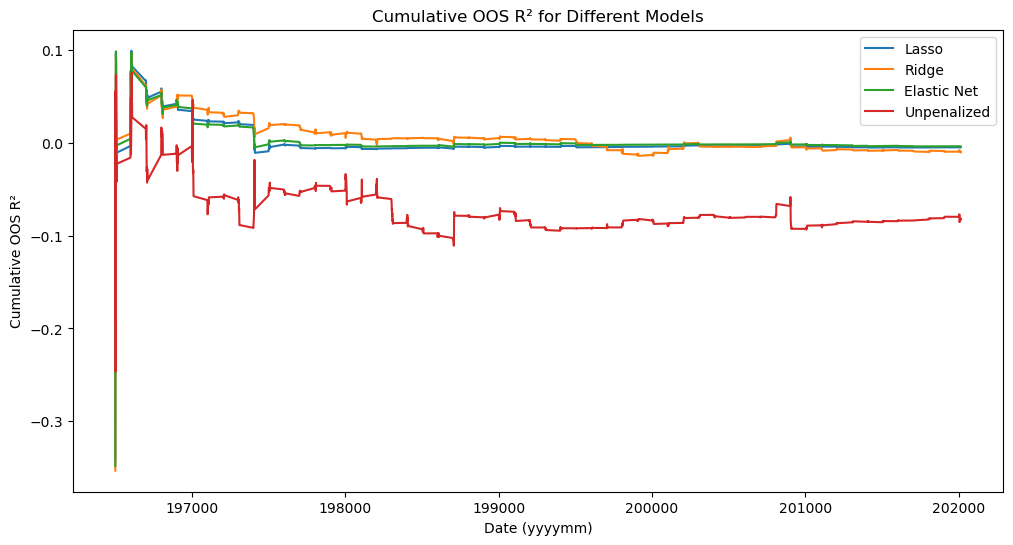

In [13]:
# Plot all OOS R^2 results to compare

# Add unpenalized regression results to dictionary
all_predictions['Unpenalized'] = unpenalized_predictions

# Calculate cumulative R^2 for each model
cumulative_r2 = {}
for name, preds in all_predictions.items():
    r2 = r2_score(all_actuals, preds)
    cumulative_r2[name] = []
    for i in range(1, len(preds)):
        actuals_so_far = all_actuals[:i+1]
        preds_so_far = preds[:i+1]
        hist_means_so_far = all_historical_means[:i+1]
        
        ss_res = np.sum((np.array(actuals_so_far) - np.array(preds_so_far))**2)
        ss_tot = np.sum((np.array(actuals_so_far) - np.array(hist_means_so_far))**2)
        r2 = 1 - (ss_res / ss_tot)
        
        cumulative_r2[name].append(r2)

# Plot cumulative R^2
dates = df.loc[start_1965+1:, 'yyyymm'].values # +1 because predictions start from start_1965
plt.figure(figsize=(12, 6))
for name in all_predictions.keys():
    plt.plot(dates, cumulative_r2[name], label=name)
plt.xlabel('Date (yyyymm)')
plt.ylabel('Cumulative OOS R²')
plt.title('Cumulative OOS R² for Different Models')
plt.legend()
plt.show()

From the plot, we can see that the penalized methods outperform the unpenalized R^2 results with R^2s much closer to 0. This means that regularization was successful in reducing overfitting by shrinking coefficients. 

However even the best penalized method, still has R^2 near 0 or slightly negative. This suggests that it is difficult to predict market returns using these predictors.

This is consistent with the efficient market hypothesis. If returns are easily predicatble using public information, then investors would exploit these patterns until they disappeared. The near-zero R^2 could be an indication that predictable patterns are already incorporated into prices. 

Simply put, there is very little predictable signal in stock returns relative to noise. 

## Part (c): RBF Features

In [14]:
# RBF Kernel Regression OOS R^2
n_features_list = [10, 25, 50, 100, 200]
rbf_oos_r2 = {}

for n_features in n_features_list:
    
    predictions = []
    actuals = []
    historical_means = []
    
    for t in range(start_1965, len(df)):
        X_train = df.loc[:t-1, predictor_columns]
        y_train = y.iloc[:t]
        X_test = df.loc[[t], predictor_columns]
        y_test = y.iloc[t]
        
        # STANDARDIZE first!
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Generate RBF features
        rbf = RBFSampler(n_components=n_features, random_state=42)
        X_train_rbf = rbf.fit_transform(X_train_scaled)
        X_test_rbf = rbf.transform(X_test_scaled)
        
        # Fit model
        linear_model.fit(X_train_rbf, y_train)
        y_pred = linear_model.predict(X_test_rbf)[0]
        
        predictions.append(y_pred)
        actuals.append(y_test)
        historical_means.append(y_train.mean())

    ss_res = np.sum((np.array(actuals) - np.array(predictions))**2)
    ss_tot = np.sum((np.array(actuals) - np.array(historical_means))**2)
    r2 = 1 - (ss_res / ss_tot)
    rbf_oos_r2[n_features] = r2
    print(f"RBF with {n_features} features - OOS R²: {r2:.6f}")

RBF with 10 features - OOS R²: -0.029270
RBF with 25 features - OOS R²: -0.073666
RBF with 50 features - OOS R²: -0.134570
RBF with 100 features - OOS R²: -0.351627
RBF with 200 features - OOS R²: -0.856327


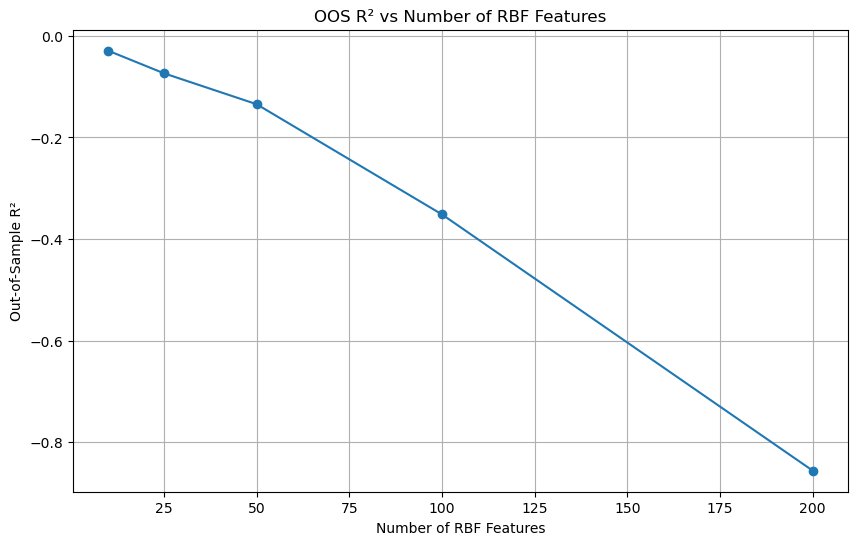

In [15]:
# Plot OOS of RBF features
plt.figure(figsize=(10, 6))
plt.plot(list(rbf_oos_r2.keys()), list(rbf_oos_r2.values()), marker='o')
plt.xlabel('Number of RBF Features')
plt.ylabel('Out-of-Sample R²')
plt.title('OOS R² vs Number of RBF Features')
plt.grid(True)
plt.show()

The RBF kernel R^2s are slightly worse than the linear models overall. The best RBF occurs with 10 features and has an R^2 of -0.033. This is comparable to the linear models but still worse than them. The linear models have R^2 much closer to 0 (R^2 of elastic net: -0.008).

Looking at the plot above, the importance of the number of features is clear: fewer features is better. The addition of features may give the model flexibility to overfit and take into account more noise, which makes predictions worse.

** did not include RBF with 500 features because the R^2 was dramatically much smaller than up to 200.

## Part (d): Rolling Windows

In [16]:
# RBF Analysis with rolling windows

window_size = [12, 36, 60, 120]
n_features = 10 # best performing from above

rolling_rbf_results = {}

for window in window_size:
    
    predictions = []
    actuals = []
    historical_means = []
    
    for t in range(start_1965, len(df)):
        # Skip if we don't have enough history yet
        if t < start_1965 + window:
            continue
        
        train_start = t - window
        X_train = df.loc[train_start:t-1, predictor_columns]
        y_train = y.iloc[train_start:t]
        
        X_test = df.loc[[t], predictor_columns]
        y_test = y.iloc[t]
        
        # STANDARDIZE first!
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Generate RBF features
        rbf = RBFSampler(n_components=n_features, random_state=42)
        X_train_rbf = rbf.fit_transform(X_train_scaled)
        X_test_rbf = rbf.transform(X_test_scaled)
        
        # Fit model
        linear_model.fit(X_train_rbf, y_train)
        y_pred = linear_model.predict(X_test_rbf)[0]

        predictions.append(y_pred)
        actuals.append(y_test)
        historical_means.append(y_train.mean())

    ss_res = np.sum((np.array(actuals) - np.array(predictions))**2)
    ss_tot = np.sum((np.array(actuals) - np.array(historical_means))**2)
    r2 = 1 - (ss_res / ss_tot)
    rolling_rbf_results[window] = r2
    print(f"Sliding Window {window} OOS R²: {r2:.6f}")

Sliding Window 12 OOS R²: -28.011472
Sliding Window 36 OOS R²: -0.417944
Sliding Window 60 OOS R²: -0.152671
Sliding Window 120 OOS R²: -0.122360


The larger the window the better the R^2. The R^2 at 12 months is extremely bad which may signal to needing more data to get a more accurate read on the data. At 120 monthes, the R^2 is -0.122 which is comparable to previous R^2 we calculated above. 

## Part (e): Cross-Validation

In [19]:
# Refitting RBF with cv

cv_folds = [3, 5, 10, 20]
n_features_list = [10, 25, 50]
rbf_cv_results = {}

for cv in cv_folds:
    
    predictions = []
    actuals = []
    historical_means = []
    
    for t in range(start_1965, len(df)):
        X_train = df.loc[:t-1, predictor_columns]
        y_train = y.iloc[:t]
        
        X_test = df.loc[[t], predictor_columns]
        y_test = y.iloc[t]
        
        # STANDARDIZE first!
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Create Pipeline 
        pipeline = Pipeline([
            ('rbf', RBFSampler(random_state=42)),
            ('lr', LinearRegression())
        ])

        param_grid = {'rbf__n_components': n_features_list}
        
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='r2')
        grid_search.fit(X_train_scaled, y_train)

        y_pred = grid_search.predict(X_test_scaled)[0]
        
        predictions.append(y_pred)
        actuals.append(y_test)
        historical_means.append(y_train.mean())

    ss_res = np.sum((np.array(actuals) - np.array(predictions))**2)
    ss_tot = np.sum((np.array(actuals) - np.array(historical_means))**2)
    r2 = 1 - (ss_res / ss_tot)
    rbf_cv_results[cv] = r2
    print(f"RBF with CV={cv} OOS R²: {r2:.6f}")

RBF with CV=3 OOS R²: -0.029270
RBF with CV=5 OOS R²: -0.029270
RBF with CV=10 OOS R²: -0.029270
RBF with CV=20 OOS R²: -0.033269


The OOS R^2 is stable across different number of CV folds. Using 3, 5, or 10 folds produces identical performance (R^2 = -0.029270), while 20 folds shows only a small deterioration. This stability indicates that the optimal number of RBF components is clear enough that different fold counts select the same hyperparameters leading to nearly identical OOS performance. 

Overall, these results demonstrate that the data is not heavily dependent on specific cross-validation method chosen. 

## Part (f): RBF with FREDMD data

In [32]:
# Load and read CSV file
fredmd = pd.read_csv('FREDMD.csv')

# Clean data
fredmd['date'] = pd.to_datetime(fredmd['date'])
fredmd = fredmd.sort_values('date')
fredmd = fredmd.ffill()

# Merge with main dataframe on date
df['date'] = pd.to_datetime(df['yyyymm'].astype(str), format='%Y%m')
df_combined = pd.merge(df[['date', 'CRSP_SPvw_minus_Rfree'] + predictor_columns], 
                       fredmd, 
                       on='date', 
                       how='inner')

df_combined = df_combined.dropna(axis=1)

all_predictors = [col for col in df_combined.columns 
                  if col not in ['date', 'CRSP_SPvw_minus_Rfree']]
y_combined = df_combined['CRSP_SPvw_minus_Rfree']
start_1965_combined = df_combined[df_combined['date'] >= '1965-01-01'].index[0]

df_combined

,date,CRSP_SPvw_minus_Rfree,dfy_lag1,infl_lag1,svar_lag1,de_lag1,lty_lag1,tms_lag1,tbl_lag1,dfr_lag1,...,M12003USM516NNBR,M12002USM511NNBR,M12003USM516NNBR.1,M1202AUSM510NNBR,M1220AUSM363SNBR,M1201AUSM348NNBR,M13021USM156NNBR,M13023USM156NNBR,M13025USM156NNBR,M09028USM474NNBR
0,1927-01-01,-0.005410,0.0100,0.000000,0.000465,-0.586175,0.0354,0.0047,0.0307,-0.0022,...,0.000000,-0.011310,0.000000,-0.006651,-0.003032,-0.004115,-0.002200,-0.007398,-0.006218,0.118064
1,1927-02-01,0.042922,0.0095,-0.011299,0.000470,-0.567601,0.0351,0.0028,0.0323,-0.0019,...,0.000000,0.008495,0.000000,0.007597,0.019048,0.010257,-0.002205,0.000000,0.002077,-0.182771
2,1927-03-01,0.004324,0.0092,-0.005714,0.000287,-0.549182,0.0347,0.0018,0.0329,-0.0019,...,0.018019,0.024142,0.018019,0.013158,0.005941,0.016195,-0.004425,-0.009950,-0.002077,0.014450
3,1927-04-01,0.010521,0.0092,-0.005747,0.000924,-0.531456,0.0331,0.0011,0.0320,-0.0170,...,-0.027151,-0.031690,-0.027151,-0.009381,0.013726,-0.006042,-0.008909,-0.010050,-0.004167,-0.126120
4,1927-05-01,0.059353,0.0090,0.000000,0.000603,-0.512916,0.0333,-0.0006,0.0339,0.0060,...,0.000000,0.012235,0.000000,0.010314,-0.004880,0.014042,-0.002240,-0.005063,-0.004184,-0.025642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,2020-08-01,0.071968,0.0117,0.005058,0.001608,-0.509646,0.0062,0.0049,0.0013,0.0323,...,0.016667,-0.095713,0.016667,0.009980,-0.035685,-0.007547,0.017700,0.016529,0.009153,0.203073
1124,2020-09-01,-0.038251,0.0102,0.003153,0.000743,-0.510916,0.0065,0.0055,0.0010,-0.0139,...,0.016667,-0.095713,0.016667,0.009980,-0.035685,-0.007547,0.017700,0.016529,0.009153,0.203073
1125,2020-10-01,-0.026509,0.0105,0.001393,0.004907,-0.512197,0.0068,0.0057,0.0011,-0.0039,...,0.016667,-0.095713,0.016667,0.009980,-0.035685,-0.007547,0.017700,0.016529,0.009153,0.203073
1126,2020-11-01,0.109303,0.0109,0.000415,0.003661,-0.501467,0.0079,0.0069,0.0010,0.0048,...,0.016667,-0.095713,0.016667,0.009980,-0.035685,-0.007547,0.017700,0.016529,0.009153,0.203073


In [33]:
predictions_macro = []
actuals_macro = []
historical_means_macro = []
n_features = 10

for t in range(start_1965_combined, len(df_combined)):
    X_train = df_combined.loc[:t-1, all_predictors]
    y_train = y_combined.iloc[:t]
    
    X_test = df_combined.loc[[t], all_predictors]
    y_test = y_combined.iloc[t]
    
    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # RBF
    rbf = RBFSampler(n_components=n_features, random_state=42)
    X_train_rbf = rbf.fit_transform(X_train_scaled)
    X_test_rbf = rbf.transform(X_test_scaled)
    
    # Fit
    linear_model.fit(X_train_rbf, y_train)
    y_pred = linear_model.predict(X_test_rbf)[0]
    
    predictions_macro.append(y_pred)
    actuals_macro.append(y_test)
    historical_means_macro.append(y_train.mean())

# Calculate R^2 with macro
ss_res_macro = np.sum((np.array(actuals_macro) - np.array(predictions_macro))**2)
ss_tot_macro = np.sum((np.array(actuals_macro) - np.array(historical_means_macro))**2)
rbf_macro_r2 = 1 - (ss_res_macro / ss_tot_macro)

print(f"RBF with FREDMD OOS R²: {rbf_macro_r2:.6f}")

RBF with FREDMD OOS R²: -0.037675


From part (c), the R^2 was -0.029270 and the R^2 with the extra factors is -0.037675. This indicates that the model performs worse than a simple historical mean benchmark. The further decline in R^2 after adding many macro variables suggests that the additional predictors introduce noise rather than finding a useful signal for forecasting. While increasing dimensionality can improve in-sample fit, it also increases the risk of overfitting. 

## Part (g): Alternative Methods

In [36]:

def expanding_oos_r2(
    X_df, y_ser, predictors, start_idx,
    fit_predict_fn,
    standardize=True
):
    predictions, actuals, historical_means = [], [], []

    for t in range(start_idx, len(X_df)):
        X_train_raw = X_df.loc[:t-1, predictors]
        y_train = y_ser.iloc[:t]
        X_test_raw  = X_df.loc[[t], predictors]
        y_test  = y_ser.iloc[t]

        scaler = None
        if standardize:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train_raw)
            X_test  = scaler.transform(X_test_raw)
        else:
            X_train = X_train_raw
            X_test  = X_test_raw

        y_pred = fit_predict_fn(X_train, y_train, X_test, scaler)
        y_pred = float(np.ravel(y_pred)[0])  # safe flatten

        predictions.append(y_pred)
        actuals.append(float(y_test))
        historical_means.append(float(y_train.mean()))

    predictions = np.array(predictions)
    actuals = np.array(actuals)
    historical_means = np.array(historical_means)

    ss_res = np.sum((actuals - predictions) ** 2)
    ss_tot = np.sum((actuals - historical_means) ** 2)
    return 1.0 - ss_res / ss_tot


In [37]:
def krr_fit_predict(alpha=1.0, gamma=None):
    def _fn(X_train, y_train, X_test, scaler):
        # X_train is scaled numpy array here
        p = X_train.shape[1]
        g = (1.0 / p) if gamma is None else gamma
        model = KernelRidge(alpha=alpha, kernel="rbf", gamma=g)
        model.fit(X_train, y_train)
        return model.predict(X_test)
    return _fn


def pcr_fit_predict(n_components=10):
    def _fn(X_train, y_train, X_test, scaler):
        k_eff = min(n_components, X_train.shape[1])
        pca = PCA(n_components=k_eff)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca  = pca.transform(X_test)

        lr = LinearRegression()
        lr.fit(X_train_pca, y_train)
        return lr.predict(X_test_pca)
    return _fn

def pls_fit_predict(n_components=10):
    def _fn(X_train, y_train, X_test, scaler):
        k_eff = min(n_components, X_train.shape[1])
        model = PLSRegression(n_components=k_eff)
        model.fit(X_train, y_train)
        return model.predict(X_test)
    return _fn

def gbr_fit_predict(n_estimators=300, learning_rate=0.05, max_depth=3):
    def _fn(X_train, y_train, X_test, scaler):
        model = GradientBoostingRegressor(
            random_state=0,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth
        )
        model.fit(X_train, y_train)
        return model.predict(X_test)
    return _fn


In [40]:
X_df = df_combined.copy()
y_ser = y_combined.copy()
predictors = all_predictors
start_idx = start_1965_combined

alt_oos_r2 = {}

# Kernel Ridge
p = len(predictors)
krr_alphas = [0.1, 1.0, 10.0]
krr_gammas = [1/p, 0.1/p, 10/p]

krr_grid = {}
for a in krr_alphas:
    for g in krr_gammas:
        r2 = expanding_oos_r2(
            X_df, y_ser, predictors, start_idx,
            fit_predict_fn=krr_fit_predict(alpha=a, gamma=g),
            standardize=True
        )
        krr_grid[(a, g)] = r2

best_krr = max(krr_grid, key=krr_grid.get)
alt_oos_r2["KernelRidge"] = krr_grid[best_krr]
print("Best KRR:", best_krr, "OOS R²:", alt_oos_r2["KernelRidge"])


# PCR
pcr_components = [3, 5, 10, 20]
pcr_grid = {}

for k in pcr_components:
    r2 = expanding_oos_r2(
        X_df, y_ser, predictors, start_idx,
        fit_predict_fn=pcr_fit_predict(n_components=k),
        standardize=True
    )
    pcr_grid[k] = r2


best_pcr = max(pcr_grid, key=pcr_grid.get)
alt_oos_r2["PCR"] = pcr_grid[best_pcr]
print("Best PCR:", best_pcr, "OOS R²:", alt_oos_r2["PCR"])


# PLS
pls_components = [3, 5, 10, 20]
pls_grid = {}

for k in pls_components:
    r2 = expanding_oos_r2(
        X_df, y_ser, predictors, start_idx,
        fit_predict_fn=pls_fit_predict(n_components=k),
        standardize=True
    )
    pls_grid[k] = r2
    

best_pls = max(pls_grid, key=pls_grid.get)
alt_oos_r2["PLS"] = pls_grid[best_pls]
print("Best PLS:", best_pls, "OOS R²:", alt_oos_r2["PLS"])

# Gradient Boosting
gbr_r2 = expanding_oos_r2(
    X_df, y_ser, predictors, start_idx,
    fit_predict_fn=gbr_fit_predict(n_estimators=300, learning_rate=0.05, max_depth=3),
    standardize=False  # trees don't need scaling
)
alt_oos_r2["GradientBoostingRegressor"] = gbr_r2
print(f"GradientBoostingRegressor -> OOS R²: {gbr_r2:.6f}")


print("\n--- Part (g) Summary: Best OOS R² by method ---")
print(pd.Series(alt_oos_r2).sort_values(ascending=False))


Best KRR: (10.0, 0.003448275862068966) OOS R²: 0.04470347145015108
Best PCR: 5 OOS R²: 0.024978956397014307
Best PLS: 5 OOS R²: -0.04714860108980101
GradientBoostingRegressor -> OOS R²: -0.241775

--- Part (g) Summary: Best OOS R² by method ---
KernelRidge                  0.044703
PCR                          0.024979
PLS                         -0.047149
GradientBoostingRegressor   -0.241775
dtype: float64


Comparing all of these methods, the Kernel Ridge has the best R^2. The other methods do not substantially improve from the original RBF in part (c). This suggests that macro predictors may contain useful information but extracting it requires regularization and nonlinear modeling. 

## Part (h): Best Model

Looking at the models run on our original dataset. 

Looking at the models run on our original dataset (w/out the FREDMD data), the model with the best R^2 is **Elastic Net**, only slightly outperforming Lasso and Ridge. 

The main reason why this is the best model is generalization. Financial return data has a very low signal to noise ratio. This means that highly flexible models tend to overfit and perform poorly OOS. Regularized linear models impose penalties that help stabilize coefficient and mitigate overfitting. 

More complex models are not always better. The other variations we went through, underperformed. Added complexity does not translate into improved forecast accuracy. 

Overall, the results suggest that equity returns are extremely difficult to forecast, and that a simple, well-regularized linear model provides the best bias–variance tradeoff.